In [14]:
# В данном блокноте производится решения той-же задачи,
# Но уже свёрточной нейронной сетью
# Комментарии будут только для обновлённых частей программы
# Если комментария нет смотреть в Mnist_conv_net.ipynb
import torch
import random
import numpy as np

#random.seed(0)
#np.random.seed(0)
#torch.manual_seed(0)
#torch.cuda.manual_seed(0)
#torch.backends.cudnn.deterministic = True

In [15]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:69: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:59: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [16]:
len(y_train), len(y_test)

(60000, 10000)

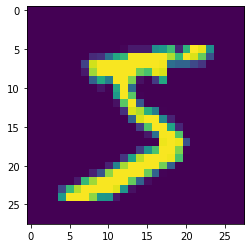

tensor(5)


In [17]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [18]:
X_train = X_train.unsqueeze(1).float() #Для свёртки нужно передать количество каналов на входе
X_test = X_test.unsqueeze(1).float() #для этого нужно добавить в тензор ещё одну размерность
#

In [19]:
X_train.shape #[количество изображений, количество каналов, высота, ширина]

torch.Size([60000, 1, 28, 28])

In [20]:
class LeNet5(torch.nn.Module): #Пишем сеть LeNet5, одну из первых свёрточных архитектур
    def __init__(self):
        super(LeNet5, self).__init__()
        #Операция свёртки принемает
        #Количество входных каналов,Количество выходных каналов,Размер ядра свёртки,Отступ
        #Важно, чтобы на вход следующей свёртки подавалось число каналов равное выходу из предыдущей
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh() #Функция активации попробывать заменить на ReLU
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2) #Пуллинг сжимает изображение
        # kernel_size - размер ядра, stride - шаг, для операции пуллинга это одно число
        # попробывать изменить на MaxPool2d
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        #В хвосте архитектуры полносвязные слои
        #Тут важно представлять размер изображения на выходе
        #из последнего свёрточного слоя
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120) 
        self.act3  = torch.nn.Tanh()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        #Операция выше вытягивает результат последней свёртки в один вектор
        #Чтобы его можно было подать в полносвязную часть сети
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x
    
lenet5 = LeNet5()

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

In [22]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

In [23]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(100):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = lenet5.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)
    
    print(accuracy)

# Для этой ячейки можно сделать внешнее прерывание, если нужно быстро закончить
# Включите гпу в среде выполнения, чтобы обучение шло быстро

tensor(0.9764)
tensor(0.9834)
tensor(0.9828)
tensor(0.9852)
tensor(0.9881)


KeyboardInterrupt: ignored

In [24]:
lenet5.forward(X_test)

tensor([[-0.6820,  0.7224, -1.1938,  ..., 13.1646, -2.0234,  1.5573],
        [ 1.5909,  2.6798, 11.5668,  ..., -2.6999,  2.0921, -5.8050],
        [-2.1532, 11.8638, -2.4575,  ...,  1.2894,  2.1719, -1.8686],
        ...,
        [-2.8630, -0.1917, -5.7553,  ...,  0.7578,  0.4004,  1.7070],
        [ 0.5835, -4.4499, -4.3265,  ..., -5.0910,  4.4999, -2.4122],
        [ 1.0510, -1.0638, -0.0556,  ..., -6.5674,  1.0094, -3.5189]],
       grad_fn=<AddmmBackward>)

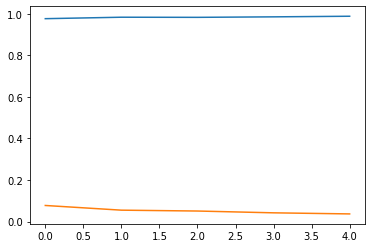

In [25]:
plt.plot(test_accuracy_history);
plt.plot(test_loss_history);